# Libraries required

In [ ]:
# 1. Uninstall the conflicting packages first to give pip a clean slate
!pip uninstall -y transformers tokenizers datasets fsspec numpy -q

# 2. Install everything together so pip can resolve dependencies
!pip install \
    transformers==4.37.2 \
    tokenizers==0.15.2 \
    peft==0.12.0 \
    accelerate==0.27.2 \
    datasets==2.21.0 \
    fsspec==2024.2.0 \
    huggingface-hub==0.24.0 \
    scikit-learn==1.5.1 \
    nltk==3.8.1 \
    rouge-score==0.1.2 \
    tabulate==0.9.0 \
    "numpy<2.0.0"

  Using cached transformers-4.37.2-py3-none-any.whl.metadata (129 kB)
  Using cached datasets-2.21.0-py3-none-any.whl.metadata (21 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
Using cached transformers-4.37.2-py3-none-any.whl (8.4 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 76.0 MB/s eta 0:00:00
Using cached datasets-2.21.0-py3-none-any.whl (527 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.0/419.0 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 91.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 1.4.1
    Uninstalling huggingface_hub-1.4.1:
      Successfully uninstalled huggingface_hub-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency c

In [ ]:
import transformers, peft, accelerate, datasets, rouge_score, nltk, tabulate, sklearn
print("All key libraries imported successfully!")
print("transformers:", transformers.__version__)
print("peft:", peft.__version__)
print("accelerate:", accelerate.__version__)
print("datasets:", datasets.__version__)
print("rouge_score: installed")
print("nltk:", nltk.__version__)
print("tabulate:", tabulate.__version__)
print("scikit-learn:", sklearn.__version__)
nltk.download('punkt', quiet=True)
print("NLTK punkt downloaded.")

All key libraries imported successfully!
transformers: 4.37.2
peft: 0.12.0
accelerate: 0.27.2
datasets: 2.21.0
rouge_score: installed
nltk: 3.8.1
tabulate: 0.9.0
scikit-learn: 1.5.1
NLTK punkt downloaded.


In [ ]:
#Loading the manually created 40 Q&A pairs used in the RAG pipeline
import json
from datasets import Dataset

with open("crypto_rag_eval_dataset.json", "r", encoding="utf-8") as f:
    eval_data = json.load(f)

# Format as instruction-style text (question → answer)
formatted = []
for item in eval_data:
    q = item["question"]
    gt = item.get("ground_truth_excerpt", "").strip()
    if gt:
        text = f"Question: {q}\nAnswer: {gt}"
        formatted.append({"text": text})

dataset = Dataset.from_list(formatted)
print(f"Dataset ready: {len(dataset)} examples")

#small train/test split used for monitoring - optional but implemented
dataset = dataset.train_test_split(test_size=0.15)  # ~34 train, ~6 val

Dataset ready: 40 examples


In [ ]:
#model loading and initialization
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
import torch

tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    "distilgpt2",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto"
)
model.config.pad_token_id = tokenizer.pad_token_id

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# LoRA config (very light)
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["c_attn", "c_proj"],  # distilgpt2 attention layers
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()  # should show ~0.5–1% trainable params

trainable params: 405,504 || all params: 82,318,080 || trainable%: 0.4926


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [ ]:
from transformers import DataCollatorForLanguageModeling

# Tokenize function
def tokenize_function(examples):
    tokenized = tokenizer(
        examples["text"],
        truncation=True,
        max_length=256,
        padding="max_length",
        return_tensors="pt"  # optional, but helps
    )
    return tokenized

# Map tokenization
tokenized_datasets = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],
    num_proc=1  # avoid multiprocessing issues on small dataset
)

# Critical: Data collator that creates labels by shifting input_ids
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # causal LM, not masked
)

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    output_dir="./peft_crypto_checkpoint",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    learning_rate=1e-4,
    fp16=torch.cuda.is_available(),  # simpler than if-else
    save_steps=50,
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    remove_unused_columns=False,  # safety
)

In [ ]:
#training with the data collator
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,          # ← THIS WAS MISSING!
)

# Train!
trainer.train()
trainer.save_model("./peft_crypto_model")
print("Fine-tuning complete. Model saved to ./peft_crypto_model")

/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:450: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Fine-tuning complete. Model saved to ./peft_crypto_model


In [ ]:
#Loading the pretrained model
print("Loading fine-tuned PEFT model...")
model = AutoModelForCausalLM.from_pretrained(
    "./peft_crypto_model",
    torch_dtype=torch.float16,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")  # same as training
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.eos_token_id

print("PEFT model loaded.")

Loading fine-tuned PEFT model...
PEFT model loaded.


In [ ]:
import json
import time
from tqdm.auto import tqdm
import torch

#Load the same 40 evaluation questions
with open("crypto_rag_eval_dataset.json", "r", encoding="utf-8") as f:
    eval_data = json.load(f)

print(f"Generating PEFT answers for {len(eval_data)} questions...")

peft_results = []
BATCH_SIZE = 8          # safe & fast on T4
MAX_NEW_TOKENS = 96     # same as RAG for fair comparison

for i in tqdm(range(0, len(eval_data), BATCH_SIZE), desc="PEFT generation"):
    batch_items = eval_data[i:i + BATCH_SIZE]
    prompts = []

    for item in batch_items:
        q = item["question"]
        prompt = f"Question: {q}\nAnswer:"
        prompts.append(prompt)

    # Batch tokenize & generate
    start_gen = time.time()
    inputs = tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    ).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            do_sample=False,  # greedy → consistent & fast
            pad_token_id=tokenizer.eos_token_id
        )

    answers = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    # Clean: remove prompt prefix
    cleaned_answers = []
    for prompt, ans in zip(prompts, answers):
        if ans.startswith(prompt):
            cleaned = ans[len(prompt):].strip()
        else:
            cleaned = ans.strip()
        cleaned_answers.append(cleaned)

    gen_time = time.time() - start_gen

    # Save per batch item
    for j, item in enumerate(batch_items):
        result = {
            "question": item["question"],
            "ground_truth_excerpt": item.get("ground_truth_excerpt", ""),
            "peft_answer": cleaned_answers[j],
            "generate_time_sec": round(gen_time / len(batch_items), 2),  # avg
        }
        peft_results.append(result)

    # Partial save
    current = i + len(batch_items)
    if current % 10 == 0 or current >= len(eval_data):
        partial_file = f"peft_outputs_partial_{current}.json"
        with open(partial_file, "w", encoding="utf-8") as f:
            json.dump(peft_results, f, ensure_ascii=False, indent=2)
        print(f"Saved partial: {partial_file}")

# Final save
with open("peft_outputs_final.json", "w", encoding="utf-8") as f:
    json.dump(peft_results, f, ensure_ascii=False, indent=2)

print(f"\nPEFT generation complete! {len(peft_results)} answers saved.")
print(f"Avg generate time per question: ~{round(sum(r['generate_time_sec'] for r in peft_results)/len(peft_results), 2)} seconds")

Generating PEFT answers for 40 questions...


PEFT generation:   0%|          | 0/5 [00:00<?, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saved partial: peft_outputs_partial_40.json

PEFT generation complete! 40 answers saved.
Avg generate time per question: ~0.23 seconds


In [ ]:
#Loading the same embedding model as in the RAG notebook
from sentence_transformers import SentenceTransformer
import numpy as np

embedder = SentenceTransformer('BAAI/bge-small-en-v1.5')
embedder.device  # should show 'cpu' or 'cuda:0' depending on runtime

print("Embedder loaded successfully.")
print(f"Embedding dimension: {embedder.get_sentence_embedding_dimension()}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedder loaded successfully.
Embedding dimension: 384


In [ ]:
#load the PEFT results
with open("peft_outputs_final.json", "r", encoding="utf-8") as f:
    peft_results = json.load(f)

print(f"Loaded {len(peft_results)} PEFT answers.")

Loaded 40 PEFT answers.


In [ ]:
import json
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from rouge_score import rouge_scorer
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt', quiet=True)

def get_embedding(text: str):
    if not text.strip():
        return np.zeros(384)
    emb = embedder.encode([text], normalize_embeddings=True, convert_to_numpy=True)
    return emb[0].astype(np.float32)

# Precompute ground-truth embeddings (once)
gt_embeddings = np.array([get_embedding(item.get("ground_truth_excerpt", "")) for item in peft_results])

rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

metrics_list = []

for idx, res in enumerate(peft_results):
    gt = res.get("ground_truth_excerpt", "").strip()
    answer = res.get("peft_answer", "").strip()

    rouge_l = rouge.score(gt, answer)['rougeL'].fmeasure if gt else 0.0

    ans_emb = get_embedding(answer)
    gt_emb = gt_embeddings[idx]
    semantic_sim = cosine_similarity([ans_emb], [gt_emb])[0][0] if np.any(gt_emb) else 0.0

    # Hallucination proxy (vs ground truth only)
    halluc_rate = 0.0
    if answer and gt:
        sentences = sent_tokenize(answer)
        if sentences:
            sent_embs = np.array([get_embedding(s) for s in sentences])
            gt_emb_2d = gt_emb.reshape(1, -1)
            max_cos = cosine_similarity(sent_embs, gt_emb_2d).max(axis=1)
            halluc_rate = (max_cos < 0.30).mean()

    metrics = {
        "question": res["question"][:80] + "..." if len(res["question"]) > 80 else res["question"],
        "rougeL": round(rouge_l, 3),
        "semantic_sim": round(semantic_sim, 3),
        "halluc_rate_proxy": round(halluc_rate, 3),
        "answer_length": len(answer.split()),
    }
    metrics_list.append(metrics)

df_peft = pd.DataFrame(metrics_list)
summary_peft = df_peft[["rougeL", "semantic_sim", "halluc_rate_proxy"]].mean().round(3)

print("\nPEFT Aggregate Metrics:")
print(summary_peft.to_string())

df_peft.to_csv("peft_metrics_detailed.csv", index=False)
summary_peft.to_csv("peft_metrics_summary.csv")

print("\nSaved PEFT metrics files.")


PEFT Aggregate Metrics:
rougeL               0.125
semantic_sim         0.666
halluc_rate_proxy    0.000

Saved PEFT metrics files.


# RAG vs Fine Tuning Comparison

In [ ]:
BASE_PATH = "./"

#load all the files for comparison and
#print to check the size distribution is the same - 40
with open(BASE_PATH + "crypto_rag_eval_dataset.json", "r", encoding="utf-8") as f:
    eval_dataset = json.load(f)

with open(BASE_PATH + "rag_outputs_final.json", "r", encoding="utf-8") as f:
    rag_results = json.load(f)

with open(BASE_PATH + "peft_outputs_final.json", "r", encoding="utf-8") as f:
    peft_results = json.load(f)

print(f"Eval: {len(eval_dataset)} | RAG outputs: {len(rag_results)} | PEFT outputs: {len(peft_results)}")

Eval: 40 | RAG outputs: 40 | PEFT outputs: 40


In [ ]:
#comparison metrics values
def compute_metrics(results, model_name="Model", has_retrieval=False):
    rows = []

    for idx, res in enumerate(results):
        gt = res.get("ground_truth_excerpt", "").strip()
        answer_key = "rag_answer" if model_name == "RAG" else "peft_answer"
        answer = res.get(answer_key, "").strip()

        rouge_l = rouge.score(gt, answer)['rougeL'].fmeasure if gt else 0.0

        ans_emb = get_embedding(answer)
        gt_emb = gt_embeddings[idx]
        sem_sim = float(cosine_similarity([ans_emb], [gt_emb])[0][0]) if np.any(gt_emb) else 0.0

        halluc = 0.0
        if answer and gt:
            sents = sent_tokenize(answer)
            if sents:
                sent_embs = np.array([get_embedding(s) for s in sents])
                cosines = cosine_similarity(sent_embs, gt_emb.reshape(1, -1)).max(axis=1)
                halluc = float((cosines < 0.30).mean())

        row = {
            "question": res["question"][:60] + "…" if len(res["question"]) > 60 else res["question"],
            f"{model_name}_rougeL": rouge_l,
            f"{model_name}_sem_sim": sem_sim,
            f"{model_name}_halluc": halluc,
            "answer_len": len(answer.split())
        }

        # Retrieval metrics only for models that have them
        if has_retrieval and "cosine_scores" in res and res["cosine_scores"]:
            scores = np.array(res["cosine_scores"])
            row[f"{model_name}_prec@3"] = (scores >= 0.5).mean()
            ranks = np.where(scores >= 0.5)[0]
            row[f"{model_name}_mrr"] = 1 / (ranks[0] + 1) if len(ranks) > 0 else 0.0
        else:
            row[f"{model_name}_prec@3"] = np.nan   # use NaN instead of string "N/A"
            row[f"{model_name}_mrr"]    = np.nan

        rows.append(row)

    df = pd.DataFrame(rows)

    # Only average the generation metrics where we ignore retrieval columns with NaN
    gen_cols = [c for c in df.columns if c.startswith(f"{model_name}_") and c not in [f"{model_name}_prec@3", f"{model_name}_mrr"]]
    avg = df[gen_cols].mean().round(3)

    # Retrieval averages (only if present - not for Fine Tuning)
    if has_retrieval:
        avg[f"{model_name}_prec@3"] = df[f"{model_name}_prec@3"].mean().round(3)
        avg[f"{model_name}_mrr"]    = df[f"{model_name}_mrr"].mean().round(3)

    print(f"\n{model_name} Averages:")
    print(avg.to_string())

    return df, avg

# Run for both
df_rag, avg_rag = compute_metrics(rag_results, "RAG", has_retrieval=True)
df_peft, avg_peft = compute_metrics(peft_results, "PEFT", has_retrieval=False)


RAG Averages:
RAG_rougeL     0.138
RAG_sem_sim    0.708
RAG_halluc     0.000
RAG_prec@3     1.000
RAG_mrr        1.000

PEFT Averages:
PEFT_rougeL     0.125
PEFT_sem_sim    0.666
PEFT_halluc     0.000


In [ ]:
# Final comparison table
comparison = pd.DataFrame(index=["RAG", "PEFT"])

comparison["rougeL"]     = [avg_rag.get("RAG_rougeL", np.nan), avg_peft.get("PEFT_rougeL", np.nan)]
comparison["sem_sim"]    = [avg_rag.get("RAG_sem_sim", np.nan), avg_peft.get("PEFT_sem_sim", np.nan)]
comparison["halluc"]     = [avg_rag.get("RAG_halluc", np.nan), avg_peft.get("PEFT_halluc", np.nan)]
comparison["prec@3"]     = [avg_rag.get("RAG_prec@3", "N/A"), "N/A"]
comparison["mrr"]        = [avg_rag.get("RAG_mrr", "N/A"), "N/A"]

comparison = comparison.round(3)

print("\nFinal RAG vs PEFT Comparison:")
print(tabulate.tabulate(comparison, headers="keys", tablefmt="simple", showindex=True))

# Save
comparison.to_csv("final_rag_vs_peft_comparison.csv")


Final RAG vs PEFT Comparison:
        rougeL    sem_sim    halluc  prec@3    mrr
----  --------  ---------  --------  --------  -----
RAG      0.138      0.708         0  1.0       1.0
PEFT     0.125      0.666         0  N/A       N/A


# Graphs

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# prepare and clean data
plot_df = comparison.copy()
plot_df = plot_df.replace("N/A", np.nan).apply(pd.to_numeric, errors='coerce')

# Mapping to full labels
rename_map = {
    "rougeL": "ROUGE-L Score",
    "sem_sim": "Semantic Similarity",
    "halluc": "Hallucination Rate"
}
plot_df = plot_df.rename(columns=rename_map)

#explicitly order columns for the chart
metrics_to_plot = ["ROUGE-L Score", "Semantic Similarity", "Hallucination Rate"]
shared_df = plot_df[metrics_to_plot]

#Setup Styling
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["font.family"] = "serif"

/tmp/ipython-input-1504448564.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_df = plot_df.replace("N/A", np.nan).apply(pd.to_numeric, errors='coerce')


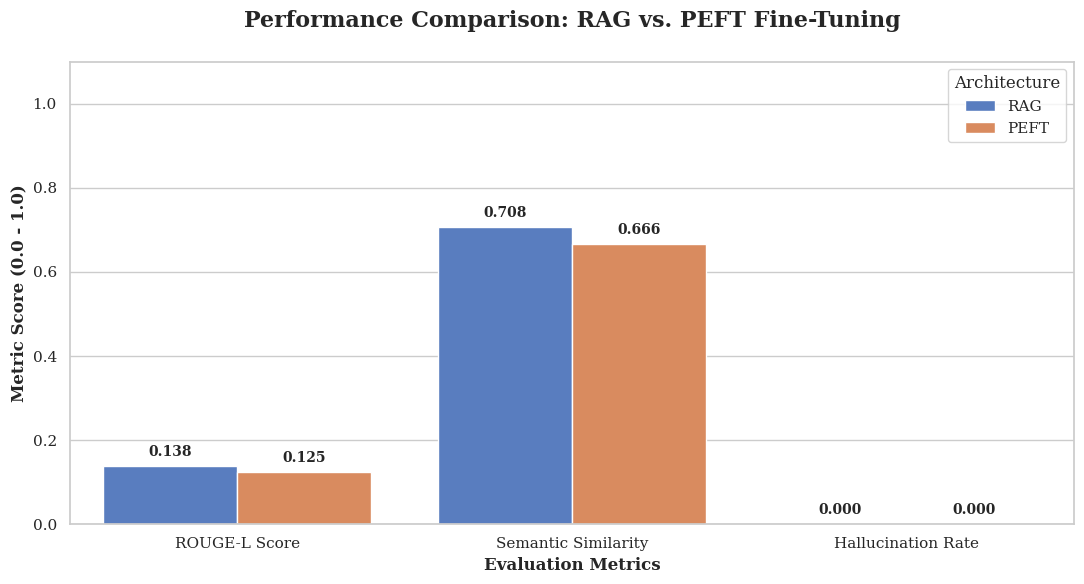

In [ ]:
#Grouped Bar Chart
tidy_df = shared_df.reset_index().rename(columns={'index': 'Model'}).melt(
    id_vars='Model', var_name='Metric', value_name='Score'
)

plt.figure(figsize=(11, 6))
ax = sns.barplot(data=tidy_df, x='Metric', y='Score', hue='Model')

plt.title('Performance Comparison: RAG vs. PEFT Fine-Tuning', fontsize=16, fontweight='bold', pad=25)
plt.ylabel('Metric Score (0.0 - 1.0)', fontsize=12, fontweight='bold')
plt.xlabel('Evaluation Metrics', fontsize=12, fontweight='bold')
plt.ylim(0, 1.1)
plt.legend(title='Architecture', loc='upper right')

for container in ax.containers:
    # This specifically labels only the bars within the data series
    labels = [f'{v.get_height():.3f}' if not np.isnan(v.get_height()) else '' for v in container]

    ax.bar_label(
        container,
        labels=labels,
        padding=5,
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig('rag_vs_peft_final_clean.png', dpi=300)
plt.show()

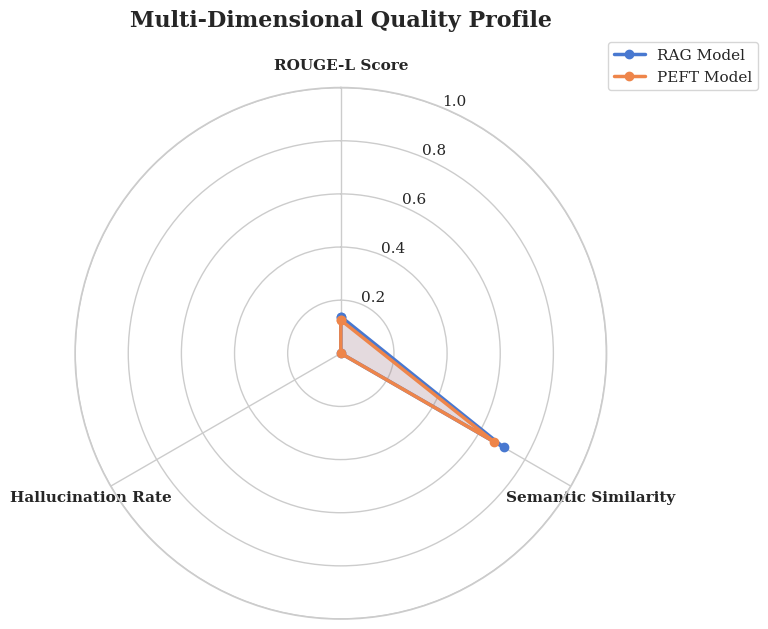

In [ ]:
labels = shared_df.columns.tolist()
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax_polar = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for i, row in shared_df.iterrows():
    values = row.values.flatten().tolist()
    values += values[:1]
    ax_polar.plot(angles, values, linewidth=2.5, label=f"{i} Model", marker='o')
    ax_polar.fill(angles, values, alpha=0.15)

ax_polar.set_theta_offset(np.pi / 2)
ax_polar.set_theta_direction(-1)
ax_polar.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=11, fontweight='bold')
ax_polar.set_ylim(0, 1)

plt.title('Multi-Dimensional Quality Profile', size=16, fontweight='bold', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.savefig('rag_vs_peft_radar_final.png', dpi=300)
plt.show()